<a href="https://colab.research.google.com/github/CienciaDatosUdea/002_EstudiantesAprendizajeEstadistico/blob/main/semestre2025-1/Sesiones/Sesion_11_SVM_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 11.1

## Mario José Félix Rojas


### CC 1.017.261.080

In [16]:
# Librerías a implementar:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_circles, make_blobs
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix

In [6]:
# Funciones auxiliares:
def make_meshgrid(x, y, h=0.02):
    """Crear malla de puntos a partir de dos features x, y."""
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    """Graficar fronteras de decisión de 'clf' sobre la grilla (xx, yy)."""
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

def plot_contoursExact(ax, clf, xx, yy, **params):
    """Versión explícita (corregida) que recibe 'clf' como argumento."""
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

1. Implementar un SVM para clasificar los siguientes datasets: make_moons, make_circles y make_bloobs, para ello se deberá crear un grid search.

In [8]:
RNG = 42  # Semilla para reproducibilidad global

In [17]:
# Funciones auxiliares
def build_pipeline_and_grid():
    """
    Devuelve:
      - pipe: Pipeline con StandardScaler y SVC
      - param_grid: búsqueda secuencial por kernel (lineal y RBF)
    """
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("svm", SVC())
    ])

    param_grid = [
        {"svm__C": [1, 10, 100, 1000], "svm__kernel": ["linear"]},
        {"svm__C": [1, 10, 100, 1000], "svm__gamma": [0.001, 0.0001], "svm__kernel": ["rbf"]},
    ]
    return pipe, param_grid

def run_grid_search(X, y, random_state=RNG, test_size=0.30, cv_splits=5):
    """
    - Split train/test estratificado.
    - GridSearchCV con StratifiedKFold (reproducible).
    Retorna:
      best_estimator, best_params, best_cv_score, test_acc, grid, (X_tr,X_te,y_tr,y_te)
    """
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )

    pipe, param_grid = build_pipeline_and_grid()

    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        cv=cv,
        n_jobs=-1,
        scoring="accuracy",
        refit=True,
        verbose=0
    )

    grid.fit(X_tr, y_tr)

    best_estimator = grid.best_estimator_
    best_params = grid.best_params_
    best_cv_score = grid.best_score_

    # Métrica en TEST (generalización)
    y_pred = best_estimator.predict(X_te)
    test_acc = accuracy_score(y_te, y_pred)

    return best_estimator, best_params, best_cv_score, test_acc, grid, (X_tr, X_te, y_tr, y_te)

def plot_best_boundary(grid_or_clf, X, y, title):
    """Dibuja la frontera de decisión del mejor modelo sobre TODOS los puntos (X,y)."""
    xx, yy = make_meshgrid(X[:, 0], X[:, 1], h=0.02)
    fig, ax = plt.subplots(figsize=(6, 5))
    plot_contours(ax, grid_or_clf, xx, yy, alpha=0.3)
    ax.scatter(X[:, 0], X[:, 1], c=y, edgecolors="k")
    ax.set_title(title)
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")
    fig.tight_layout()
    plt.show()

In [18]:
# Generación de datasets
#   * make_moons
#   * make_circles
#   * make_blob

X_moons,   y_moons   = make_moons(n_samples=600, noise=0.25, random_state=RNG)
X_circles, y_circles = make_circles(n_samples=600, noise=0.10, factor=0.4, random_state=RNG)
X_blobs,   y_blobs   = make_blobs(n_samples=600, centers=3, cluster_std=1.5, random_state=RNG)


In [19]:
# Entrenamiento + selección de hiperparámetros + evaluación
#   Para cada dataset:
#   - Ejecutamos GridSearchCV
#   - Imprimimos mejores hiperparámetros, accuracy CV y accuracy en test

results = []

best_moons, params_moons, cv_moons, test_moons, grid_moons, splits_moons = run_grid_search(X_moons, y_moons)
print("[make_moons]")
print("  - Mejores hiperparámetros:", params_moons)
print(f"  - CV mean accuracy (5-fold): {cv_moons:.4f}")
print(f"  - Test accuracy: {test_moons:.4f}\n")
results.append(("make_moons", params_moons, cv_moons, test_moons))

best_circles, params_circles, cv_circles, test_circles, grid_circles, splits_circles = run_grid_search(X_circles, y_circles)
print("[make_circles]")
print("  - Mejores hiperparámetros:", params_circles)
print(f"  - CV mean accuracy (5-fold): {cv_circles:.4f}")
print(f"  - Test accuracy: {test_circles:.4f}\n")
results.append(("make_circles", params_circles, cv_circles, test_circles))

best_blobs, params_blobs, cv_blobs, test_blobs, grid_blobs, splits_blobs = run_grid_search(X_blobs, y_blobs)
print("[make_blobs]")
print("  - Mejores hiperparámetros:", params_blobs)
print(f"  - CV mean accuracy (5-fold): {cv_blobs:.4f}")
print(f"  - Test accuracy: {test_blobs:.4f}\n")
results.append(("make_blobs", params_blobs, cv_blobs, test_blobs))

[make_moons]
  - Mejores hiperparámetros: {'svm__C': 100, 'svm__gamma': 0.001, 'svm__kernel': 'rbf'}
  - CV mean accuracy (5-fold): 0.8690
  - Test accuracy: 0.8444

[make_circles]
  - Mejores hiperparámetros: {'svm__C': 1000, 'svm__gamma': 0.001, 'svm__kernel': 'rbf'}
  - CV mean accuracy (5-fold): 0.9881
  - Test accuracy: 0.9944

[make_blobs]
  - Mejores hiperparámetros: {'svm__C': 1, 'svm__kernel': 'linear'}
  - CV mean accuracy (5-fold): 1.0000
  - Test accuracy: 1.0000



2. Con los mejores párametros dibujar  las fronteras de clasificación

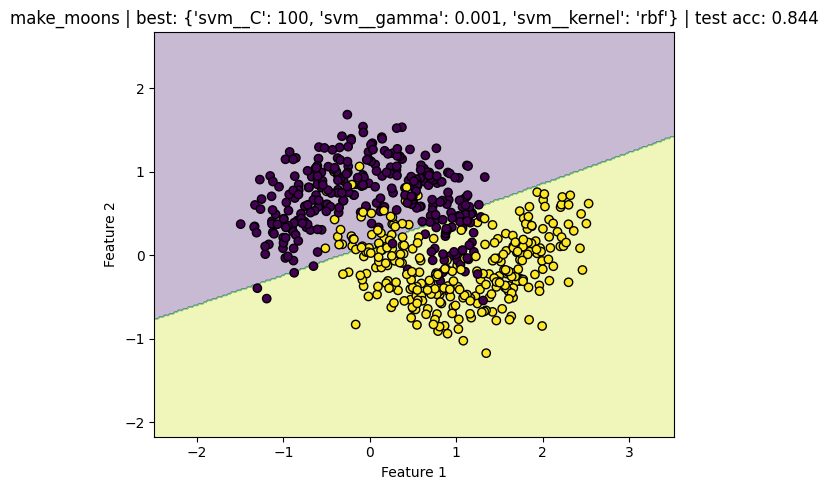

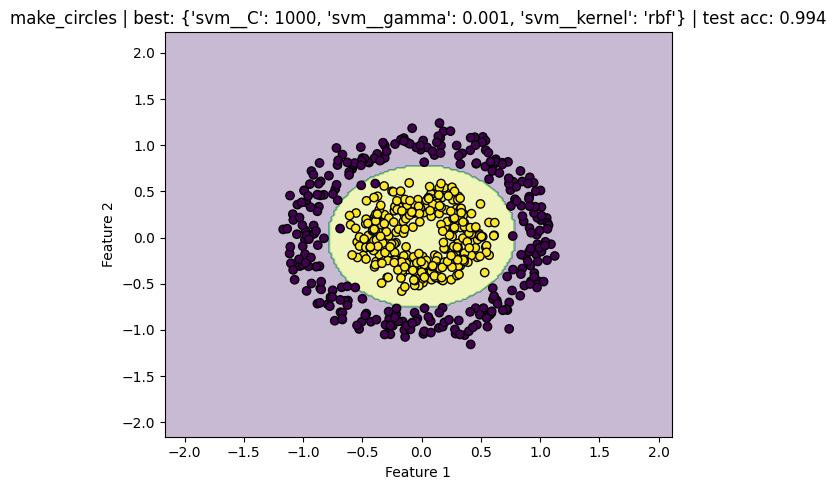

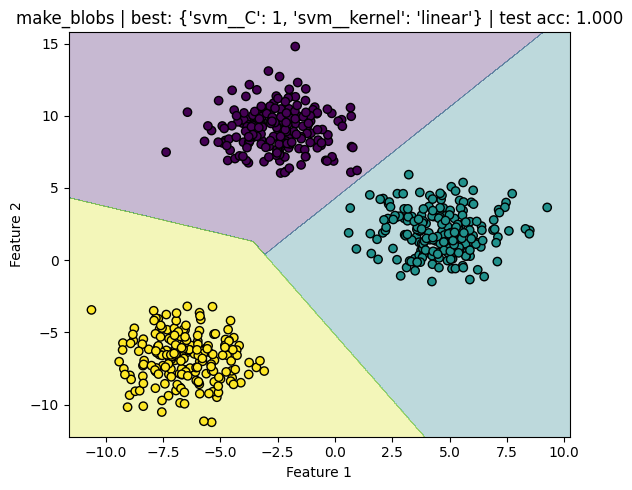

In [20]:
plot_best_boundary(grid_moons,   X_moons,   y_moons,
                   title=f"make_moons | best: {params_moons} | test acc: {test_moons:.3f}")
plot_best_boundary(grid_circles, X_circles, y_circles,
                   title=f"make_circles | best: {params_circles} | test acc: {test_circles:.3f}")
plot_best_boundary(grid_blobs,   X_blobs,   y_blobs,
                   title=f"make_blobs | best: {params_blobs} | test acc: {test_blobs:.3f}")

# ----------------

3. Con los mejores parámetros dibujar la matriz de confusion

In [ ]:
def print_confusion_matrix(title, estimator, splits):
    X_tr, X_te, y_tr, y_te = splits
    y_pred = estimator.predict(X_te)
    labels = np.unique(y_te)  # asegura orden consistente de etiquetas
    cm = confusion_matrix(y_te, y_pred, labels=labels)
    print(title)
    print("Etiquetas (orden de filas/columnas):", labels)
    print(cm, "\n")

print_confusion_matrix("Matriz de confusión - make_moons",   best_moons,   splits_moons)
print_confusion_matrix("Matriz de confusión - make_circles", best_circles, splits_circles)
print_confusion_matrix("Matriz de confusión - make_blobs",   best_blobs,   splits_blobs)


Matriz de confusión - make_moons (TEST)
Etiquetas (orden de filas/columnas): [0 1]
[[72 18]
 [10 80]] 

Matriz de confusión - make_circles (TEST)
Etiquetas (orden de filas/columnas): [0 1]
[[89  1]
 [ 0 90]] 

Matriz de confusión - make_blobs (TEST)
Etiquetas (orden de filas/columnas): [0 1 2]
[[60  0  0]
 [ 0 60  0]
 [ 0  0 60]] 

